In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import MinMaxScaler

from keras import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
#Import data and give column names

train = pd.read_csv('../../data/feature_selected_train_FD001.csv', sep=',', header=0, engine='python')
test = pd.read_csv('../../data/feature_selected_test_FD001.csv', sep=',', header=0, engine='python')
y_test = pd.read_csv('../../data/RUL_FD001.csv', sep=',', header=0,  engine='python')

index_names = train.columns[[0, 1]]
setting_names = train.columns[[2]]
sensor_names = train.drop(index_names.union(setting_names), axis = 1).columns # Find something better than union!!
scale_columns = sensor_names
keep_columns = scale_columns.union(index_names[[1]])

In [14]:
def scale_data(train, test, columns):
    sc = MinMaxScaler()
    scaled_train = train.copy()
    scaled_test = test.copy()
    scaled_train[columns] = pd.DataFrame(sc.fit_transform(scaled_train[columns]))
    scaled_test[columns] = pd.DataFrame(sc.transform(scaled_test[columns]))
    return scaled_train, scaled_test

def add_remaining_useful_life(df):
    grouped_by_unit = df.groupby(by="unit_no")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_no', right_index=True)
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

def train_val_group_split(x_data, y_data, gss, groups, print_groups=True):
    for idx_train, idx_val in gss.split(x_data, y_data, groups=groups):
        if print_groups:
            print('train_split_engines', x_data.iloc[idx_train]['unit_no'].unique())
            print('validate_split_engines', x_data.iloc[idx_val]['unit_no'].unique(), '\n')

        x_train = x_data.iloc[idx_train].copy()
        y_train = y_data.iloc[idx_train].copy()
        x_val = x_data.iloc[idx_val].copy()
        y_val = y_data.iloc[idx_val].copy()
    return x_train, y_train, x_val, y_val

def plot_loss(history):
    plt.figure(figsize=(13,5))
    plt.plot(range(1, len(history.history['loss'])+1), history.history['loss'], label='Train')
    plt.plot(range(1, len(history.history['val_loss'])+1), history.history['val_loss'], label='Validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def evaluate(y_true, y_hat, label):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

def plot_predictions(y_true, y_predicted):
    plt.figure(figsize=(13,5))
    plt.plot(y_true, label='True Value')
    plt.plot(y_predicted, label='Predicted Value' )
    plt.xlabel('Samples')
    plt.ylabel('Predictions')
    plt.legend()
    plt.show()

In [4]:
x_train = add_remaining_useful_life(train)
x_train_scaled, x_test_scaled = scale_data(x_train, test, scale_columns)
gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=1) 
x_train, y_train, x_val, y_val = train_val_group_split(x_train_scaled.drop(['RUL'], axis = 1),
                                                       x_train_scaled[['RUL', 'unit_no']],
                                                       gss, x_train_scaled['unit_no'])
x_test = x_test_scaled.groupby(by="unit_no").last().reset_index()

y_train = y_train.drop(['unit_no'], axis = 1)
y_val = y_val.drop(['unit_no'], axis = 1)

train_split_engines [  1   2   3   4   5   6   7   8   9  10  12  13  14  15  16  17  19  20
  21  22  23  24  25  26  27  28  29  30  31  35  36  38  39  41  42  43
  44  46  47  48  49  50  51  54  55  56  58  59  60  61  62  63  64  65
  67  68  69  71  72  73  74  75  76  77  78  80  84  86  87  88  89  90
  91  92  95  96  97  98  99 100]
validate_split_engines [11 18 32 33 34 37 40 45 52 53 57 66 70 79 81 82 83 85 93 94] 



In [5]:
model = Sequential()
model.add(Dense(128, input_dim = x_train[keep_columns].shape[1], activation = 'relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 12,417
Trainable params: 12,417
Non-trainable params: 0
_________________________________________________________________


In [6]:
model_name = 'mlp'
epochs = 20
save_best_model = ModelCheckpoint('{}.hdf5'.format(model_name), save_best_only=True, monitor='val_loss', mode='min')
history = model.fit(x_train[keep_columns], y_train,
                    validation_data = (x_val[keep_columns], y_val),
                    epochs = epochs,
                    batch_size=128,
                    callbacks = [save_best_model])

Train on 16663 samples, validate on 3968 samples
Epoch 1/20
16663/16663 [==============================] - 0s 22us/step - loss: 10758.0308 - val_loss: 3218.3970
Epoch 2/20
16663/16663 [==============================] - 0s 13us/step - loss: 2408.5231 - val_loss: 1410.1173
Epoch 3/20
16663/16663 [==============================] - 0s 12us/step - loss: 1908.4479 - val_loss: 1303.1906
Epoch 4/20
16663/16663 [==============================] - 0s 13us/step - loss: 1707.0700 - val_loss: 1183.4375
Epoch 5/20
16663/16663 [==============================] - 0s 12us/step - loss: 1634.8166 - val_loss: 1361.8551
Epoch 6/20
16663/16663 [==============================] - 0s 14us/step - loss: 1575.8938 - val_loss: 1147.2763
Epoch 7/20
16663/16663 [==============================] - 0s 12us/step - loss: 1540.8142 - val_loss: 1229.3286
Epoch 8/20
16663/16663 [==============================] - 0s 12us/step - loss: 1555.1137 - val_loss: 1391.0618
Epoch 9/20
16663/16663 [==============================] - 0s 1

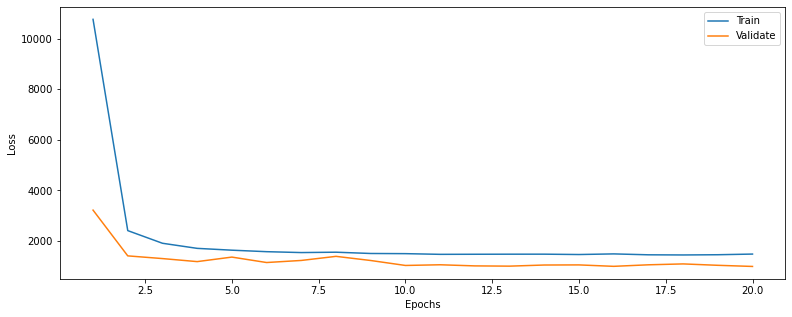

In [7]:
plot_loss(history)

In [8]:
y_hat_train = model.predict(x_train[keep_columns])
evaluate(y_train, y_hat_train, 'Train')

y_hat_val = model.predict(x_val[keep_columns])
evaluate(y_val, y_hat_val, 'Validation')

y_hat_test = model.predict(x_test[keep_columns])
evaluate(y_test, y_hat_test, 'Test')

Train set RMSE:38.89555690833088, R2:0.6915959382299558
Validation set RMSE:31.50007546981218, R2:0.7538036290861272
Test set RMSE:24.773787928212577, R2:0.644593564961679


(16663, 1) (16663, 1)


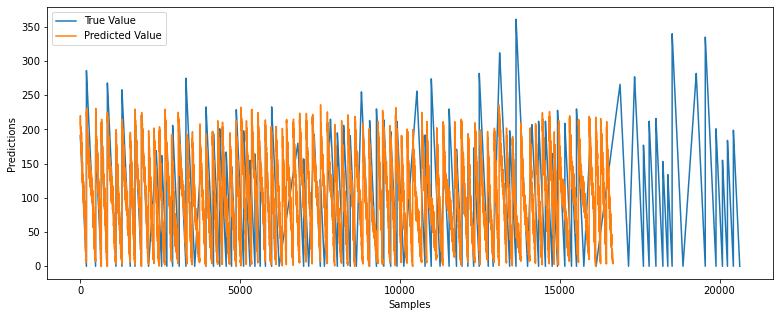

       RUL
0      191
1      190
2      189
3      188
4      187
...    ...
20626    4
20627    3
20628    2
20629    1
20630    0

[16663 rows x 1 columns]


In [15]:
print(y_train.shape, y_hat_train.shape)
plot_predictions(y_train, y_hat_train)
print(y_train)

(3968, 1) (3968, 1)


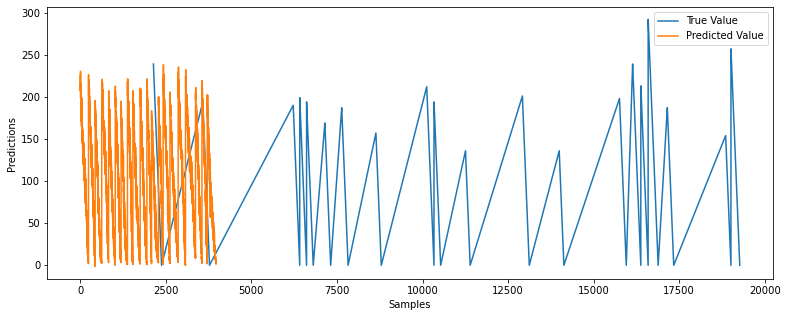

In [10]:
print(y_val.shape, y_hat_val.shape)
plot_predictions(y_val, y_hat_val)

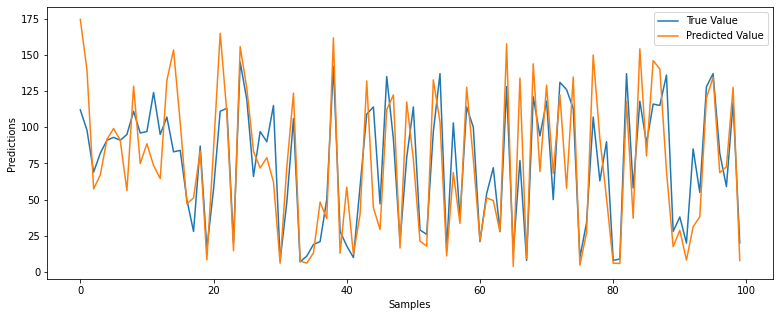

In [11]:
plot_predictions(y_test, y_hat_test)